## `5_taichi.ipynb`

In [1]:
import copy
import os
# Remove warning when importing Taichi due to old glibc
os.environ["TI_MANYLINUX2014_OK"] = "1"
import taichi as ti
import numpy as np
from IPython.display import Markdown as md

[Taichi] version 1.6.0, llvm 16.0.0git, commit f1c6fbbd, linux, python 3.9.4


[I 08/30/23 23:45:20.210 11327] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


In [2]:
from common import initialize_field, plot_field, save_result, compare_results, read_results

In [3]:
NX = 128
NY = 128
NZ = 80
N_ITER = 50

From Taichi document:

> Taichi is embedded in Python and uses modern just-in-time (JIT) frameworks (for example LLVM, SPIR-V) to offload the Python source code to native GPU or CPU instructions, offering the performance at both development time and runtime.

Like Numba, Taichi is a very big module, with special solutions to graphic visualization, spacially sparde data processing and deep learning. Here we only focus on its basic application and compare its performance with NumPy. 

## Pointwise Stencil

The first thing we need to do here is to initiate the Taichi kernel, with which the backend utilized and the default data type can be defined. We will first start with x64 CPUs.

### CPU backend

In [4]:
ti.init(arch=ti.cpu, default_fp=ti.f64)

[Taichi] Starting on arch=x64


Then we transplant the array for-loop codes to taichi acceleration codes using `@ti.kernel` decorator. Like Gt4Py, you have to predefine the datatype of the variables, here `ti.types.ndarray` so that NumPy array can be accepted. You can also define functions only usable by `kernel` with `@ti.func` decorator. However, as is said in Taichi document:

> In Taichi, a kernel is allowed to have a maximum of one return value, which could either be a scalar, ti.types.matrix(), or ti.types.vector().

In our case we cannot have our 3D stencil as a proper return value. Moreover, there are further limitations as we cannot do easy swap of two arrays by just exchanging their pointers as we do in pure python code `in_field, out_field = out_field, in_field`. The reason is explained in the document:

> Direct value assignments lead to semantic ambiguity. For example, a = b can mean data copy if a is pre-defined, or otherwise can serve to define and initialize a.

However, the supported `ti.copy_from()` command will be even slower as it copies value-by-value on the memory level. Therefore, the better way is to swap the two stencils outside Taichi kernel.

In [5]:
@ti.kernel
def taichi_ndarray_equal_pointwise(
    in_field: ti.types.ndarray(dtype=ti.f64, ndim=3),
    out_field: ti.types.ndarray(dtype=ti.f64, ndim=3)
):
    for k in range(NZ): # Will be parallelized
        for j in range(NY):
            for i in range(NX):
                out_field[k, j, i] = in_field[k, j, i]
                # taichi doesn't support an ndarray output, so there's no return value

def taichi_ndarray_pointwise(in_field, out_field): # There's no easy copying for ti.ndarray, so we do that outside kernel
    for n in range(N_ITER):
        taichi_ndarray_equal_pointwise(in_field, out_field)
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
    return out_field

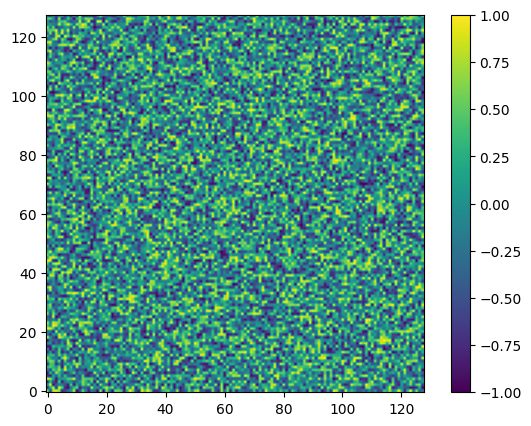

In [6]:
in_field = initialize_field(NX, NY, NZ)
out_field = np.empty((NZ,NY,NX))
out_field = taichi_ndarray_pointwise(in_field, out_field)
plot_field(out_field)

In [7]:
%%timeit -o in_field = initialize_field(NX, NY, NZ); out_field = np.empty((NZ,NY,NX))
out_field = taichi_ndarray_pointwise(in_field, out_field)

114 ms ± 242 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 114 ms ± 242 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [8]:
result_taichi_ndarray_cpu_pointwise = _
save_result(result_taichi_ndarray_cpu_pointwise, "taichi_ndarray_cpu_pointwise")

In [9]:
time_list_pointwise = read_results("list_pointwise")
time_array_pointwise = read_results("array_pointwise")

ti_vs_list = compare_results(result_taichi_ndarray_cpu_pointwise.average, time_list_pointwise, "faster")
ti_vs_array = compare_results(result_taichi_ndarray_cpu_pointwise.average, time_array_pointwise, "faster")

md(f"""
The used Taichi codes are **{ti_vs_list} times faster than the pure Python list codes** and **{ti_vs_array} times faster than 
the array codes**. However, NumPy and other DSL codes are much faster, maybe because Taichi is poor at copying between objects.
""")


The used Taichi codes are **~72 times faster than the pure Python list codes** and **~133 times faster than 
the array codes**. However, NumPy and other DSL codes are much faster, maybe because Taichi is poor at copying between objects.


Taichi manages parallel for-loops using multiple codes in a somewhat rigid way: only the outermost layer for-loop will be run parallelly, which is automatic and needs an extra code `ti.loop_config(serialize=True)` to prevent it. In this pointwise copying case we can involve all three dimensions `i`, `j` and `k` into parallel computation, and Taichi allows that with `ti.ndrange()` command to loop over the whole data field.

In [10]:
@ti.kernel
def taichi_ndarray_equal_more_parallel_pointwise(
    in_field: ti.types.ndarray(dtype=ti.f64, ndim=3),
    out_field: ti.types.ndarray(dtype=ti.f64, ndim=3)
):
    for k, j, i in ti.ndrange(NZ, NY, NX): # Will be parallelized
        out_field[k, j, i] = in_field[k, j, i]

def taichi_ndarray_more_parallel_pointwise(in_field, out_field):
    for n in range(N_ITER):
        taichi_ndarray_equal_more_parallel_pointwise(in_field, out_field)
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
    return out_field

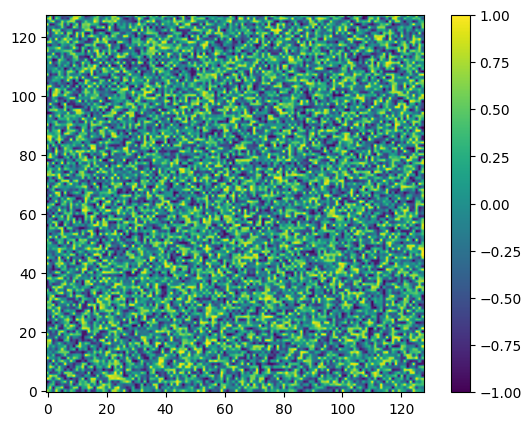

In [11]:
in_field = initialize_field(NX, NY, NZ)
out_field = np.empty((NZ,NY,NX))
out_field = taichi_ndarray_more_parallel_pointwise(in_field, out_field)
plot_field(out_field)

In [12]:
%%timeit -o in_field = initialize_field(NX, NY, NZ); out_field = np.empty((NZ,NY,NX))
out_field = taichi_ndarray_more_parallel_pointwise(in_field, out_field)

44.1 ms ± 1.51 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 44.1 ms ± 1.51 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [13]:
result_taichi_ndarray_parallel_cpu_pointwise = _
save_result(result_taichi_ndarray_parallel_cpu_pointwise, "taichi_ndarray_parallel_cpu_pointwise")

In [14]:
ti_parallel_vs_ti = compare_results(
    result_taichi_ndarray_parallel_cpu_pointwise.average,
    result_taichi_ndarray_cpu_pointwise.average,
    "faster"
)

md(f"""
With a more parallel for-loop we see the codes become **{ti_parallel_vs_ti} times faster than the original ones with 
parallelization only on Z dimension**, as it fully exploits each core and assigns their workloads better. This leads to an 
interesting question if the sequence of `ti.ndrange` affects the overall performance.
""")


With a more parallel for-loop we see the codes become **~2.6 times faster than the original ones with 
parallelization only on Z dimension**, as it fully exploits each core and assigns their workloads better. This leads to an 
interesting question if the sequence of `ti.ndrange` affects the overall performance.


In [15]:
@ti.kernel
def taichi_ndarray_equal_more_parallel_XYZ_pointwise(
    in_field: ti.types.ndarray(dtype=ti.f64, ndim=3),
    out_field: ti.types.ndarray(dtype=ti.f64, ndim=3)
):
    for i, j, k in ti.ndrange(NX, NY, NZ): # Will be parallelized
        out_field[k, j, i] = in_field[k, j, i]

def taichi_ndarray_more_parallel_XYZ_pointwise(in_field, out_field):
    for n in range(N_ITER):
        taichi_ndarray_equal_more_parallel_XYZ_pointwise(in_field, out_field)
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
    return out_field

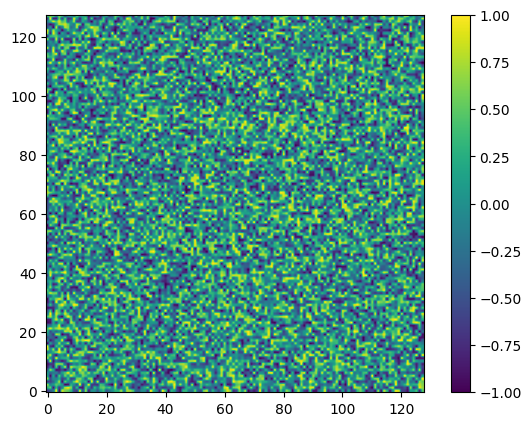

In [16]:
in_field = initialize_field(NX, NY, NZ)
out_field = np.empty((NZ,NY,NX))
out_field = taichi_ndarray_more_parallel_XYZ_pointwise(in_field, out_field)
plot_field(out_field)

In [17]:
%%timeit -o in_field = initialize_field(NX, NY, NZ); out_field = np.empty((NZ,NY,NX))
out_field = taichi_ndarray_more_parallel_XYZ_pointwise(in_field, out_field)

110 ms ± 437 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 110 ms ± 437 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)>

And it does! Seems like `ti.ndrange` sequence will decide the actually for-loop sequence and it won't optimize according to the array memory layout, which we've already discussed in the [previous Notebook](./1_lists_numpy.ipynb). According to this optimizing result, **we will always use the parallel for-loop in the codes of the following parts**.

Next let's switch the array datatype from `ndarray` to `ti.field`, as is mentioned in the document:

> Fields in Taichi are the global data containers, which can be accessed from both the Python scope and the Taichi scope. Just like an ndarray in NumPy or a tensor in PyTorch, a field in Taichi is defined as a multi-dimensional array of elements, and elements in a field can be a Scalar, a Vector, a Matrix, or a Struct.

We learn from the instruction that `ti.field` is specialized for physical simulation, where vector fields, matrix fields and structs(like in C++, a group of variables) will be very useful.

This message also gives another hint that it would be better for `ti.field` to be global variables, which is actually the commen workflow of Taichi. This however brings another problem. As mentioned in Taichi document:

> In Taichi, a kernel treats global variables as compile-time constants. This means that it takes in the current values of the global variables at the time it is compiled and does not track changes to them afterwards.

Therefore, if you want to operate on `ti.field` using kernels, you can only use them once in the code. In our case, whenever we want to run the kernel on a different input, we have to recompile the kernel by initializing Taichi again to update global variables in the kernel.

One more thing worth noticing is that `ti.field` again doesn't support pointer swap codes. So we need to use `ti.field.copy_from()` this time.

Now let's change the datatype from `ti.ndarray` to `ti.field` and see how it goes:

In [18]:
@ti.kernel
def taichi_field_equal_more_parallel_pointwise():
    for k, j, i in ti.ndrange(NZ, NY, NX): # Will be parallelized
        out_field[k, j, i] = in_field[k, j, i]

def taichi_field_more_parallel_pointwise(in_field, out_field):
    for n in range(N_ITER):
        taichi_field_equal_more_parallel_pointwise()
        if n < N_ITER - 1:
            in_field.copy_from(out_field)
    return out_field

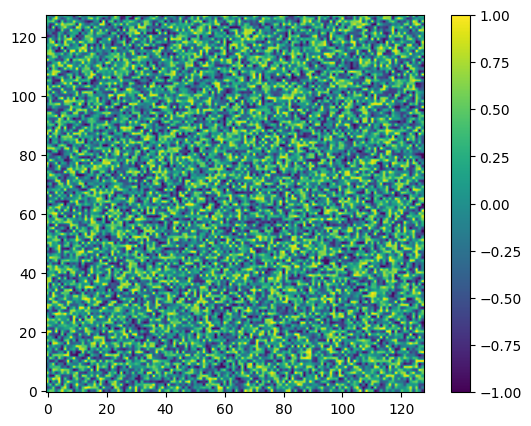

In [19]:
in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)) # first initialize ti.field
in_field.from_numpy(initialize_field(NX, NY, NZ)) # then fill the field with the np.ndarray
out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
out_field.from_numpy(np.empty((NZ,NY,NX)))
out_field = taichi_field_more_parallel_pointwise(in_field, out_field)
out_field = out_field.to_numpy() # return the field back to np.ndarray
plot_field(out_field)

In [20]:
%%timeit -o in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); in_field.from_numpy(initialize_field(NX, NY, NZ)); out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); out_field.from_numpy(np.empty((NZ,NY,NX)))
out_field = taichi_field_more_parallel_pointwise(in_field, out_field)

62.3 ms ± 1.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 62.3 ms ± 1.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [21]:
result_taichi_field_parallel_cpu_pointwise = _
save_result(result_taichi_field_parallel_cpu_pointwise, "taichi_field_parallel_cpu_pointwise")

The `ti.field` version is actually slower than the `ti.ndarray` version. This might be mainly because of the lagging of `copy_from` function.

Now let's inspect sine calculation pointwise. Taichi provides the sine function `ti.sin()` that can be implemented on scalars. We will check the ndarray version and the field version respectively.

In [22]:
@ti.kernel
def taichi_ndarray_equal_more_parallel_sin_pointwise(
    in_field: ti.types.ndarray(dtype=ti.f64, ndim=3),
    out_field: ti.types.ndarray(dtype=ti.f64, ndim=3)
):
    for i, j, k in ti.ndrange(NX, NY, NZ): # Will be parallelized
        out_field[k, j, i] = ti.sin(in_field[k, j, i])

def taichi_ndarray_more_parallel_sin_pointwise(in_field, out_field):
    for n in range(N_ITER):
        taichi_ndarray_equal_more_parallel_sin_pointwise(in_field, out_field)
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
    return out_field

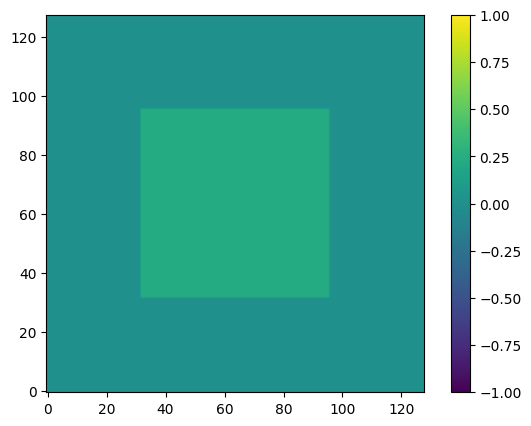

In [23]:
in_field = initialize_field(NX, NY, NZ, mode="square")
out_field = np.empty((NZ,NY,NX))
out_field = taichi_ndarray_more_parallel_sin_pointwise(in_field, out_field)
plot_field(out_field)

In [24]:
%%timeit -o in_field = initialize_field(NX, NY, NZ); out_field = np.empty((NZ,NY,NX))
out_field = taichi_ndarray_more_parallel_sin_pointwise(in_field, out_field)

266 ms ± 4.99 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 266 ms ± 4.99 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [25]:
result_taichi_ndarray_parallel_cpu_sin_pointwise = _
save_result(result_taichi_ndarray_parallel_cpu_sin_pointwise, "taichi_ndarray_parallel_cpu_sin_pointwise")

In [26]:
@ti.kernel
def taichi_field_equal_more_parallel_sin_pointwise():
    for k, j, i in ti.ndrange(NZ, NY, NX):
        out_field[k, j, i] = ti.sin(in_field[k, j, i])

def taichi_field_more_parallel_sin_pointwise(in_field, out_field):
    for n in range(N_ITER):
        taichi_field_equal_more_parallel_sin_pointwise()
        if n < N_ITER - 1:
            in_field.copy_from(out_field)
    return out_field

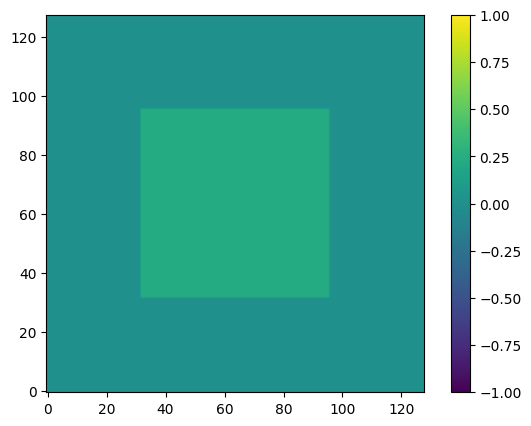

In [27]:
in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
in_field.from_numpy(initialize_field(NX, NY, NZ, mode="square"))
out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
out_field.from_numpy(np.empty((NZ,NY,NX)))
taichi_field_more_parallel_sin_pointwise(in_field, out_field)
out_field = out_field.to_numpy()
plot_field(out_field)

In [28]:
%%timeit -o in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); in_field.from_numpy(initialize_field(NX, NY, NZ)); out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); out_field.from_numpy(np.empty((NZ,NY,NX)))
out_field = taichi_field_more_parallel_sin_pointwise(in_field, out_field)

74.7 ms ± 768 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 74.7 ms ± 768 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [29]:
result_taichi_field_parallel_cpu_sin_pointwise = _
save_result(result_taichi_field_parallel_cpu_sin_pointwise, "taichi_field_parallel_cpu_sin_pointwise")

In [30]:
time_list_sin_pointwise = read_results("list_sin_pointwise")
time_array_sin_pointwise = read_results("array_sin_pointwise")
time_numpy_sin_pointwise = read_results("numpy_sin_pointwise")
ti_ndarray_vs_lists = compare_results(result_taichi_ndarray_parallel_cpu_sin_pointwise.average, time_list_sin_pointwise, "faster")
ti_field_vs_ti_ndarray = compare_results(
    result_taichi_field_parallel_cpu_sin_pointwise.average,
    result_taichi_ndarray_parallel_cpu_sin_pointwise.average,
    "faster"
)
ti_ndarray_vs_numpy = compare_results(result_taichi_ndarray_parallel_cpu_sin_pointwise.average, time_numpy_sin_pointwise,"faster")

md(f"""
For sine calculation, Taichi code using `ti.ndarray` is **{ti_ndarray_vs_lists} times faster than pure python code (lists)** and 
**{ti_ndarray_vs_numpy} times faster than vectorized NumPy arrays**. By applying `ti.field` instead of `ti.ndarray`, the code 
speed can be **{ti_field_vs_ti_ndarray} times even faster**, comparable to Numba and NumExpr. `ti.field` now seems to gain enough 
advantages over `ti.ndarray` to overcome the `copy_from` lagging by optimizing sine calculation.
""")


For sine calculation, Taichi code using `ti.ndarray` is **~55 times faster than pure python code (lists)** and 
**~3.3 times faster than vectorized NumPy arrays**. By applying `ti.field` instead of `ti.ndarray`, the code 
speed can be **~3.6 times even faster**, comparable to Numba and NumExpr. `ti.field` now seems to gain enough 
advantages over `ti.ndarray` to overcome the `copy_from` lagging by optimizing sine calculation.


Now let's check if the codes run even faster on GPU backends.

### GPU backend

One advantage of using Taichi is that the backend switching is convenient. With a simple `ti.init(arch=ti.gpu)` you can reinitiate the Taichi kernal to the GPU backend.

In [31]:
ti.init(arch=ti.gpu, default_fp=ti.f64)

[Taichi] Starting on arch=cuda


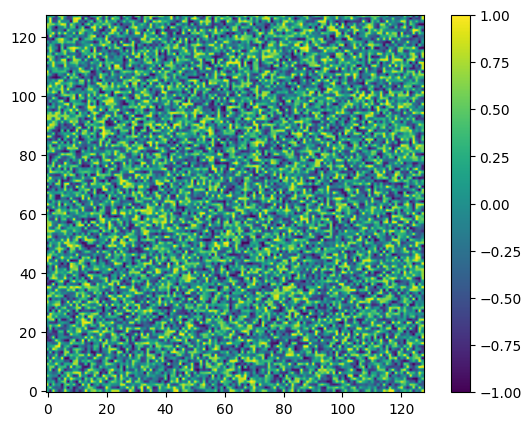

In [32]:
in_field = initialize_field(NX, NY, NZ)
out_field = np.empty((NZ,NY,NX))
out_field = taichi_ndarray_pointwise(in_field, out_field)
plot_field(out_field)

In [33]:
%%timeit -o in_field = initialize_field(NX, NY, NZ); out_field = np.empty((NZ,NY,NX))
out_field = taichi_ndarray_pointwise(in_field, out_field)

446 ms ± 449 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 446 ms ± 449 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)>

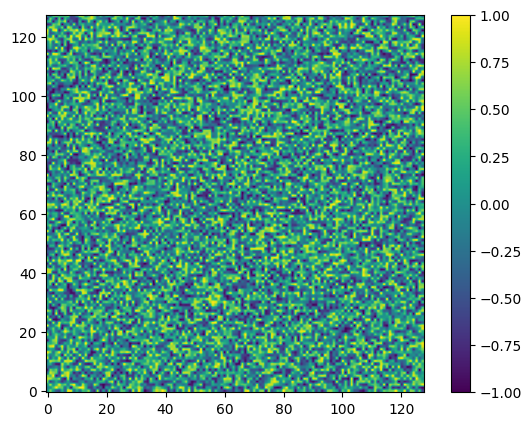

In [34]:
in_field = initialize_field(NX, NY, NZ)
out_field = np.empty((NZ,NY,NX))
out_field = taichi_ndarray_more_parallel_pointwise(in_field, out_field)
plot_field(out_field)

In [35]:
%%timeit -o in_field = initialize_field(NX, NY, NZ); out_field = np.empty((NZ,NY,NX))
out_field = taichi_ndarray_more_parallel_pointwise(in_field, out_field)

252 ms ± 324 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 252 ms ± 324 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [36]:
result_taichi_ndarray_parallel_gpu_pointwise = _
save_result(result_taichi_ndarray_parallel_gpu_pointwise, "taichi_ndarray_parallel_gpu_pointwise")

In [37]:
md(f"""
When dealing with `ti.ndarray`, CUDA backend is even slower than x64 CPUs 
({result_taichi_ndarray_parallel_cpu_pointwise.average * 1e3:.1f}ms when running parallel). It seems that Taichi doesn't optimize 
the `ti.ndarray` operation on CPU backend.
""")


When dealing with `ti.ndarray`, CUDA backend is even slower than x64 CPUs 
(44.1ms when running parallel). It seems that Taichi doesn't optimize 
the `ti.ndarray` operation on CPU backend.


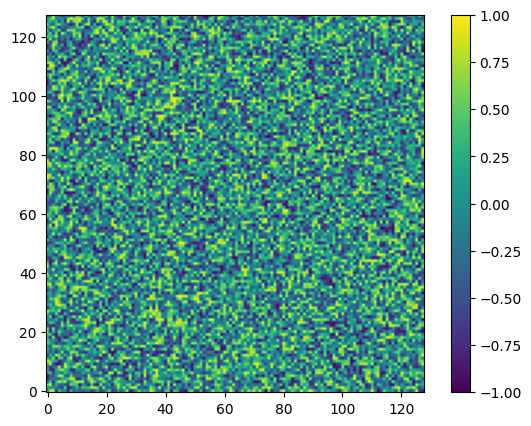

In [38]:
in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)) # first initialize ti.field
in_field.from_numpy(initialize_field(NX, NY, NZ)) # then fill the field with the np.ndarray
out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
out_field.from_numpy(np.empty((NZ,NY,NX)))
out_field = taichi_field_more_parallel_pointwise(in_field, out_field)
out_field = out_field.to_numpy() # return the field back to np.ndarray
plot_field(out_field)

In [39]:
%%timeit -o in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); in_field.from_numpy(initialize_field(NX, NY, NZ)); out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); out_field.from_numpy(np.empty((NZ,NY,NX)))
out_field = taichi_field_more_parallel_pointwise(in_field, out_field)

22.4 ms ± 2.61 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 22.4 ms ± 2.61 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [40]:
result_taichi_field_parallel_gpu_pointwise = _
save_result(result_taichi_field_parallel_gpu_pointwise, "taichi_field_parallel_gpu_pointwise")

In [41]:
ti_gpu_vs_ti_cpu = compare_results(
    result_taichi_field_parallel_gpu_pointwise.average,
    result_taichi_ndarray_parallel_cpu_pointwise.average,
    "faster"
)

ti_field_vs_ti_ndarray = compare_results(
    result_taichi_field_parallel_gpu_pointwise.average,
    result_taichi_ndarray_parallel_gpu_pointwise.average,
    "faster"
)

md(f"""
When it comes to `ti.field` version, GPU backend boosts the performance, and it's **{ti_gpu_vs_ti_cpu} times faster than the CPU 
version**, and **{ti_field_vs_ti_ndarray} times faster than the `ti.ndarray` version on GPU**. This speed is comparable to other 
DSLs. `ti.field` seems to be the better format for Taichi GPU acceleration.
""")


When it comes to `ti.field` version, GPU backend boosts the performance, and it's **~2.0 times faster than the CPU 
version**, and **~11 times faster than the `ti.ndarray` version on GPU**. This speed is comparable to other 
DSLs. `ti.field` seems to be the better format for Taichi GPU acceleration.


In [42]:
time_numpy_pointwise = read_results("numpy_pointwise")
time_numba_parallel_pointwise = read_results("numba_parallel_pointwise")
time_gt4py_numpy_pointwise = read_results("gt4py_numpy_pointwise")
time_numexpr_pointwise =  read_results("numexpr_pointwise")

md(f"""
| Function                                     | Time                                                                |
|:---------------------------------------------|--------------------------------------------------------------------:|
| `list_pointwise()`                           |  {time_list_pointwise}s                                             |
| `array_pointwise()`                          |  {time_array_pointwise}s                                            |
| `numpy_pointwise()`                          |  {time_numpy_pointwise * 1e6:.1f}μs                                 |
| `numba_parallel_pointwise()`                 |  {time_numba_parallel_pointwise * 1e3:.1f}ms                        |
| `gt4py_numpy_pointwise()`                    |  {time_gt4py_numpy_pointwise * 1e3:.1f}ms                           |
| `numexpr_pointwise()`                        |  {time_numexpr_pointwise * 1e3:.1f}ms                               |
| `taichi_ndarray_cpu_pointwise()`             |  {result_taichi_ndarray_cpu_pointwise.average * 1e3:.1f}ms          |
| `taichi_ndarray_parallel_cpu_pointwise()`    |  {result_taichi_ndarray_parallel_cpu_pointwise.average * 1e3:.1f}ms |
| `taichi_field_parallel_cpu_pointwise()`      |  {result_taichi_field_parallel_cpu_pointwise.average * 1e3:.1f}ms   |
| `taichi_ndarray_parallel_gpu_pointwise()`    |  {result_taichi_ndarray_parallel_gpu_pointwise.average * 1e3:.1f}ms |
| `taichi_field_parallel_gpu_pointwise()`      |  {result_taichi_field_parallel_gpu_pointwise.average * 1e3:.1f}ms   |

""")


| Function                                     | Time                                                                |
|:---------------------------------------------|--------------------------------------------------------------------:|
| `list_pointwise()`                           |  8.21s                                             |
| `array_pointwise()`                          |  15.1s                                            |
| `numpy_pointwise()`                          |  35.8μs                                 |
| `numba_parallel_pointwise()`                 |  3.2ms                        |
| `gt4py_numpy_pointwise()`                    |  2.9ms                           |
| `numexpr_pointwise()`                        |  12.8ms                               |
| `taichi_ndarray_cpu_pointwise()`             |  113.8ms          |
| `taichi_ndarray_parallel_cpu_pointwise()`    |  44.1ms |
| `taichi_field_parallel_cpu_pointwise()`      |  62.3ms   |
| `taichi_ndarray_parallel_gpu_pointwise()`    |  252.5ms |
| `taichi_field_parallel_gpu_pointwise()`      |  22.4ms   |



Now let's inspect sine calculation pointwise on GPU backend.

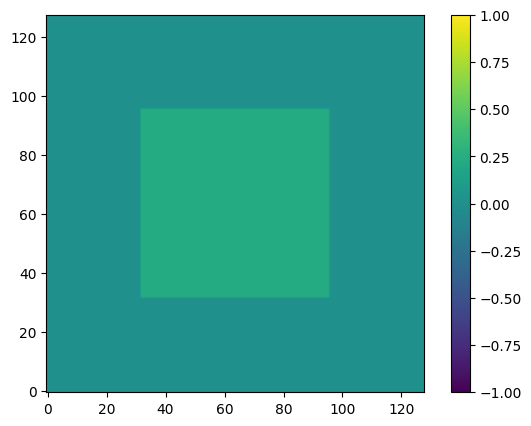

In [43]:
in_field = initialize_field(NX, NY, NZ, mode="square")
out_field = np.empty((NZ,NY,NX))
out_field = taichi_ndarray_more_parallel_sin_pointwise(in_field, out_field)
plot_field(out_field)

In [44]:
%%timeit -o in_field = initialize_field(NX, NY, NZ); out_field = np.empty((NZ,NY,NX))
out_field = taichi_ndarray_more_parallel_sin_pointwise(in_field, out_field)

261 ms ± 268 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 261 ms ± 268 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [45]:
result_taichi_ndarray_parallel_gpu_sin_pointwise = _
save_result(result_taichi_ndarray_parallel_gpu_sin_pointwise, "taichi_ndarray_parallel_gpu_sin_pointwise")

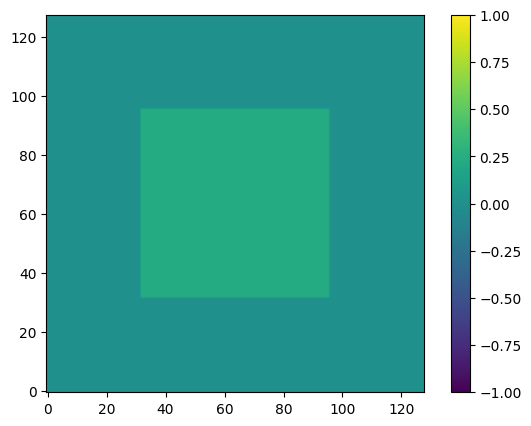

In [46]:
in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
in_field.from_numpy(initialize_field(NX, NY, NZ, mode="square"))
out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
out_field.from_numpy(np.empty((NZ,NY,NX)))
taichi_field_more_parallel_sin_pointwise(in_field, out_field)
out_field = out_field.to_numpy()
plot_field(out_field)

In [47]:
%%timeit -o in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); in_field.from_numpy(initialize_field(NX, NY, NZ)); out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); out_field.from_numpy(np.empty((NZ,NY,NX)))
out_field = taichi_field_more_parallel_sin_pointwise(in_field, out_field)

15.5 ms ± 309 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 15.5 ms ± 309 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [48]:
result_taichi_field_parallel_gpu_sin_pointwise = _
save_result(result_taichi_field_parallel_gpu_sin_pointwise, "taichi_field_parallel_gpu_sin_pointwise")

In [49]:
ti_gpu_vs_ti_cpu = compare_results(
    result_taichi_field_parallel_gpu_sin_pointwise.average,
    result_taichi_field_parallel_cpu_sin_pointwise.average,
    "faster"
)

md(f"""

For sine calculation, the GPU backend is also **{ti_gpu_vs_ti_cpu} times faster than CPU with `ti.field` data container**, 
obtaining the fastest sin calculation speed so far, while the `ti.ndarray` version doesn't see much change compared to that with 
CPU backend.
""")



For sine calculation, the GPU backend is also **~4.8 times faster than CPU with `ti.field` data container**, 
obtaining the fastest sin calculation speed so far, while the `ti.ndarray` version doesn't see much change compared to that with 
CPU backend.


In [50]:
time_numba_parallel_sin_pointwise = read_results("numba_parallel_sin_pointwise")
time_numexpr_sin_pointwise =  read_results("numexpr_sin_pointwise")

md(f"""
| Function                                         | Time                                                                    |
|:-------------------------------------------------|------------------------------------------------------------------------:|
| `list_sin_pointwise()`                           |  {time_list_sin_pointwise}s                                             |
| `array_sin_pointwise()`                          |  {time_array_sin_pointwise}s                                            |
| `numpy_sin_pointwise()`                          |  {time_numpy_sin_pointwise * 1e3:.1f}ms                                 |
| `numba_parallel_sin_pointwise()`                 |  {time_numba_parallel_sin_pointwise * 1e3:.1f}ms                        |
| `numexpr_sin_pointwise()`                        |  {time_numexpr_sin_pointwise * 1e3:.1f}ms                               |
| `taichi_ndarray_parallel_cpu_sin_pointwise()`    |  {result_taichi_ndarray_parallel_cpu_sin_pointwise.average * 1e3:.1f}ms |
| `taichi_field_parallel_cpu_sin_pointwise()`      |  {result_taichi_field_parallel_cpu_sin_pointwise.average * 1e3:.1f}ms   |
| `taichi_ndarray_parallel_gpu_sin_pointwise()`    |  {result_taichi_ndarray_parallel_gpu_sin_pointwise.average * 1e3:.1f}ms |
| `taichi_field_parallel_gpu_sin_pointwise()`      |  {result_taichi_field_parallel_gpu_sin_pointwise.average * 1e3:.1f}ms   |

""")


| Function                                         | Time                                                                    |
|:-------------------------------------------------|------------------------------------------------------------------------:|
| `list_sin_pointwise()`                           |  14.5s                                             |
| `array_sin_pointwise()`                          |  22.6s                                            |
| `numpy_sin_pointwise()`                          |  875.0ms                                 |
| `numba_parallel_sin_pointwise()`                 |  61.6ms                        |
| `numexpr_sin_pointwise()`                        |  86.7ms                               |
| `taichi_ndarray_parallel_cpu_sin_pointwise()`    |  265.9ms |
| `taichi_field_parallel_cpu_sin_pointwise()`      |  74.7ms   |
| `taichi_ndarray_parallel_gpu_sin_pointwise()`    |  261.2ms |
| `taichi_field_parallel_gpu_sin_pointwise()`      |  15.5ms   |



So which one do we choose as the data container between `ti.ndarray` and `ti.field`? Taichi document actually gives an answer:

> You can use fields as data containers in most cases. However, fields might have very complicated tree-structured layouts with even sparsity in them. It is hard for external libraries to interpret or use computed results stored in ti.field directly. An ndarray, however, always allocates a contiguous memory block to allow straightforward data exchange with external libraries.

In our case, Taichi data will not interact frequently with external codes, so **let's stick to `ti.field` to get a better performance with GPU backend**.

## 1D Stencil

### Same Column: $a(i,j) = \frac{1}{2} \Big[b(i+1,j) - b(i,j)\Big]$

Now we examine the performance of Taichi on accelerating 1D stencil.

#### CPU backend

In [51]:
ti.init(arch=ti.cpu, default_fp=ti.f64)

[Taichi] Starting on arch=x64


In [52]:
@ti.kernel
def taichi_field_diff_1D_same_col():
    for k, j in ti.ndrange(NZ, NY):
        for i in range(NX-1):
            out_field[k, j, i] = 0.5 * (in_field[k, j, i+1] - in_field[k, j, i])
        out_field[k, j, NX-1] = 0.5 * (in_field[k, j, 0] - in_field[k, j, NX-1])

def taichi_field_1D_same_col(in_field, out_field):
    for n in range(N_ITER):
        taichi_field_diff_1D_same_col()
        if n < N_ITER - 1:
            in_field.copy_from(out_field)
    return out_field

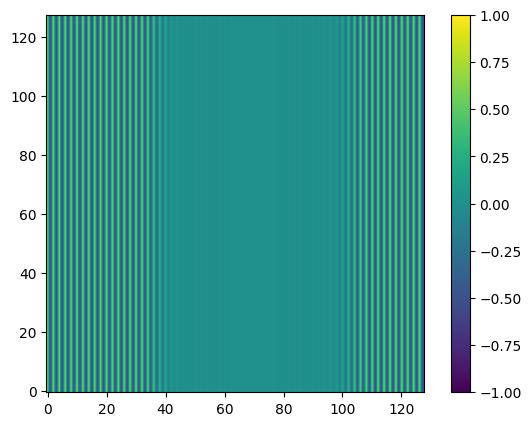

In [53]:
in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
in_field.from_numpy(initialize_field(NX, NY, NZ, mode="vertical-bars"))
out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
out_field.from_numpy(np.empty((NZ,NY,NX)))
out_field = taichi_field_1D_same_col(in_field, out_field)
out_field = out_field.to_numpy()
plot_field(out_field)

In [54]:
%%timeit -o in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); in_field.from_numpy(initialize_field(NX, NY, NZ)); out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); out_field.from_numpy(np.empty((NZ,NY,NX)))
out_field = taichi_field_1D_same_col(in_field, out_field)

61.8 ms ± 689 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 61.8 ms ± 689 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [55]:
result_taichi_cpu_1D_same_col = _
save_result(result_taichi_cpu_1D_same_col, "taichi_cpu_1D_same_col")

In [56]:
time_list_1D_same_col = read_results("list_1D_same_col_ZYX")
time_numpy_1D_same_col = read_results("numpy_1D_same_col")
time_numba_1D_same_col = read_results("numba_1D_same_col")
time_gt4py_1D_same_col = read_results("gt4py_kfirst_1D_same_col")
time_numexpr_1D_same_col = read_results("numexpr_1D_same_col")
ti_1D_col_vs_list_1D_col = compare_results(result_taichi_cpu_1D_same_col.average, time_list_1D_same_col)
ti_1D_col_vs_numpy_1D_col = compare_results(result_taichi_cpu_1D_same_col.average, time_numpy_1D_same_col, "faster-%")
ti_1D_col_vs_numexpr_1D_col = compare_results(result_taichi_cpu_1D_same_col.average, time_numexpr_1D_same_col, "faster-%")

md(f"""
The running time of Taichi codes is **{ti_1D_col_vs_list_1D_col} times faster than pure python codes** 
and **{ti_1D_col_vs_numpy_1D_col} faster than numpy array**. Numba and Gt4Py still perform much better (
{time_numba_1D_same_col * 1e3:.1f}ms and {time_gt4py_1D_same_col * 1e3:.1f}ms respectively), but it's also 
{ti_1D_col_vs_numexpr_1D_col} faster than NumExpr, thanks to both parallelization and JIT acceleration of Taichi.
""")


The running time of Taichi codes is **~241 times faster than pure python codes** 
and **~83% faster than numpy array**. Numba and Gt4Py still perform much better (
3.6ms and 7.3ms respectively), but it's also 
~58% faster than NumExpr, thanks to both parallelization and JIT acceleration of Taichi.


Similar to GT4Py mentioned in [the previous notebook](./3_gt4py.ipynb), when converting from `np.ndarray` to `ti.field`, the memory layout changes to the same sequence. Different memory layout can be realized with `ti.root`. Below is an example:

[Taichi] Starting on arch=x64


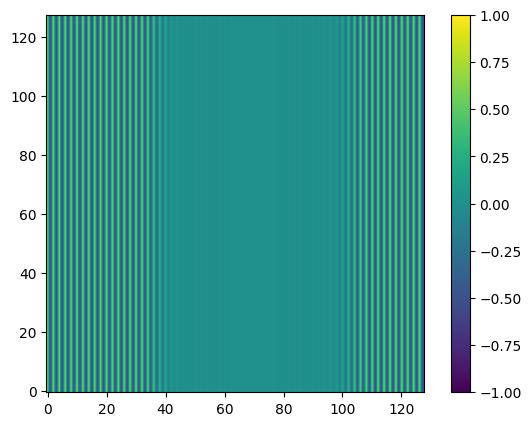

In [57]:
# Here we are calling the same function, so we reinitialize the kernel first
ti.init(arch=ti.cpu, default_fp=ti.f64)
in_field = ti.field(dtype=ti.f64)
ti.root.dense(ti.i, NZ).dense(ti.j, NY).dense(ti.k, NX).place(in_field) # Re-order the ti.field in ZYX sequence
in_field.from_numpy(initialize_field(NX, NY, NZ, mode="vertical-bars"))
out_field = ti.field(dtype=ti.f64)
ti.root.dense(ti.i, NZ).dense(ti.j, NY).dense(ti.k, NX).place(out_field) # Same re-ordering
out_field.from_numpy(np.empty((NZ,NY,NX)))
out_field = taichi_field_1D_same_col(in_field, out_field)
out_field = out_field.to_numpy()
plot_field(out_field)

In [58]:
%%timeit -o in_field = ti.field(dtype=ti.f64); ti.root.dense(ti.i, NZ).dense(ti.j, NY).dense(ti.k, NX).place(in_field); in_field.from_numpy(initialize_field(NX, NY, NZ)); out_field = ti.field(dtype=ti.f64); ti.root.dense(ti.i, NZ).dense(ti.j, NY).dense(ti.k, NX).place(out_field); out_field.from_numpy(np.empty((NZ,NY,NX)))
out_field = taichi_field_1D_same_col(in_field, out_field)

61.8 ms ± 791 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 61.8 ms ± 791 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In the example above, the memory layout would be the same as a C-style layout: i-indices are continuous, then j-indices, and k-indices at last. And it turns out that the performance is similar to the version without `ti.root` settings.

Now let's try the other way round, i.e. a Fortran-style layout:

[Taichi] Starting on arch=x64


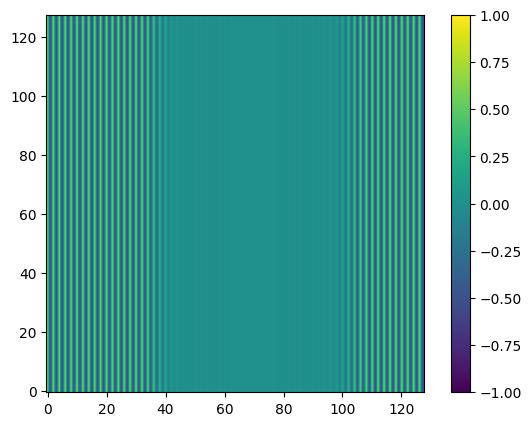

In [59]:
# Here we are calling the same function, so we reinitialize the kernel first
ti.init(arch=ti.cpu, default_fp=ti.f64)
in_field = ti.field(dtype=ti.f64)
ti.root.dense(ti.k, NX).dense(ti.j, NY).dense(ti.i, NZ).place(in_field) # Re-order the ti.field in XYZ sequence
in_field.from_numpy(initialize_field(NX, NY, NZ, mode="vertical-bars"))
out_field = ti.field(dtype=ti.f64)
ti.root.dense(ti.k, NX).dense(ti.j, NY).dense(ti.i, NZ).place(out_field) # Same re-ordering
out_field.from_numpy(np.empty((NZ,NY,NX)))
out_field = taichi_field_1D_same_col(in_field, out_field)
out_field = out_field.to_numpy()
plot_field(out_field)

In [60]:
%%timeit -o in_field = ti.field(dtype=ti.f64); ti.root.dense(ti.k, NX).dense(ti.j, NY).dense(ti.i, NZ).place(in_field); in_field.from_numpy(initialize_field(NX, NY, NZ)); out_field = ti.field(dtype=ti.f64); ti.root.dense(ti.k, NX).dense(ti.j, NY).dense(ti.i, NZ).place(out_field); out_field.from_numpy(np.empty((NZ,NY,NX)))
out_field = taichi_field_1D_same_col(in_field, out_field)

161 ms ± 1.33 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 161 ms ± 1.33 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>

As expected, the run with Fortran-style memory layout is much slower because it doesn't fit the 1D stencil columnwise processing, as discussed in [the previous list and numpy notebook](./1_lists_numpy.ipynb).

Now we inspect another data structure of Taichi: `Vector field`. In our case, it looks very promising that we define each row as a vector, and place each vector into a 2D `ti.field`, i.e. `field[k, j][i]`. We might be able to see a performance change with this data structure.

In [61]:
@ti.kernel
def taichi_vec_diff_1D_same_col():
    for k, j in ti.ndrange(NZ, NY):
        for i in range(NX-1):
            out_field[k, j][i] = 0.5 * (in_field[k, j][i+1] - in_field[k, j][i])
        out_field[k, j][NX-1] = 0.5 * (in_field[k, j][0] - in_field[k, j][NX-1])

def taichi_vec_1D_same_col(in_field, out_field):
    for n in range(N_ITER):
        taichi_vec_diff_1D_same_col()
        if n < N_ITER - 1:
            in_field.copy_from(out_field)
    return out_field

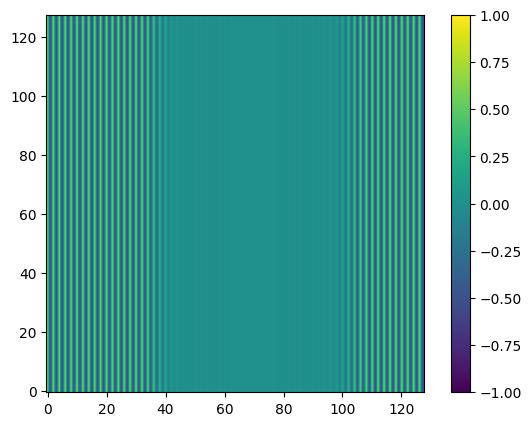

In [62]:
in_field = ti.Vector.field(n=NX, dtype=ti.f64, shape=(NZ,NY))
in_field.from_numpy(initialize_field(NX, NY, NZ, mode="vertical-bars"))
out_field = ti.Vector.field(n=NX, dtype=ti.f64, shape=(NZ,NY))
out_field.from_numpy(np.empty((NZ,NY,NX)))
out_field = taichi_vec_1D_same_col(in_field, out_field)
out_field = out_field.to_numpy()
plot_field(out_field)

In [63]:
%%timeit -o in_field = ti.Vector.field(n=NX, dtype=ti.f64, shape=(NZ,NY)); in_field.from_numpy(initialize_field(NX, NY, NZ)); out_field = ti.Vector.field(n=NX, dtype=ti.f64, shape=(NZ,NY)); out_field.from_numpy(np.empty((NZ,NY,NX)))
out_field = taichi_vec_1D_same_col(in_field, out_field)

61.3 ms ± 1.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 61.3 ms ± 1.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>

And it turns out to be similar to the 3D `ti.field` result. However, this seems not to be a good way to manage the data according to the warning message that appears when we read in the element in vector field:

> Taichi matrices/vectors with 128x1 > 32 entries are not suggested. Matrices/vectors will be automatically unrolled at compile-time for performance. So the compilation time could be extremely long if the matrix size is too big. You may use a field to store a large matrix like this, e.g.: `x = ti.field(ti.f32, (128, 1))`.

This illustrates that vectors and matrices in Taichi are adviced to be small to fit in the cache and stay fast. Now let's see the performance with GPU backend.

#### GPU backend

In [64]:
ti.init(arch=ti.gpu, default_fp=ti.f64)

[Taichi] Starting on arch=cuda


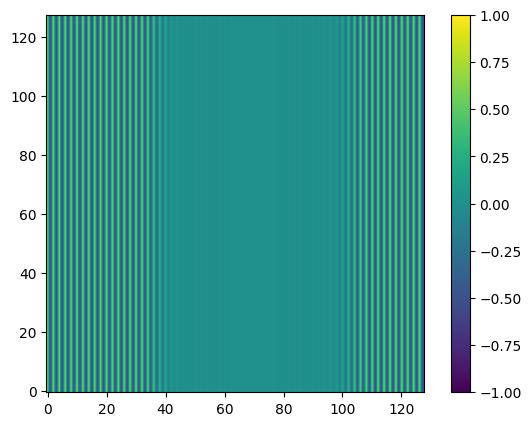

In [65]:
in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
in_field.from_numpy(initialize_field(NX, NY, NZ, mode="vertical-bars"))
out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
out_field.from_numpy(np.empty((NZ,NY,NX)))
out_field = taichi_field_1D_same_col(in_field, out_field)
out_field = out_field.to_numpy()
plot_field(out_field)

In [66]:
%%timeit -o in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); in_field.from_numpy(initialize_field(NX, NY, NZ)); out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); out_field.from_numpy(np.empty((NZ,NY,NX)))
out_field = taichi_field_1D_same_col(in_field, out_field)

21.9 ms ± 2.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 21.9 ms ± 2.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [67]:
result_taichi_gpu_1D_same_col = _
save_result(result_taichi_gpu_1D_same_col, "taichi_gpu_1D_same_col")

In [68]:
taichi_gpu_vs_taichi_cpu = compare_results(result_taichi_gpu_1D_same_col.average, result_taichi_cpu_1D_same_col.average)
taichi_gpu_vs_numpy = compare_results(result_taichi_gpu_1D_same_col.average, time_numpy_1D_same_col)

md(f"""
Under GPU backend the 1D stencil becomes **{taichi_gpu_vs_taichi_cpu} times faster than CPU backend**, or **{taichi_gpu_vs_numpy} 
times faster than numpy solution**.
""")


Under GPU backend the 1D stencil becomes **~2.8 times faster than CPU backend**, or **~5.2 
times faster than numpy solution**.


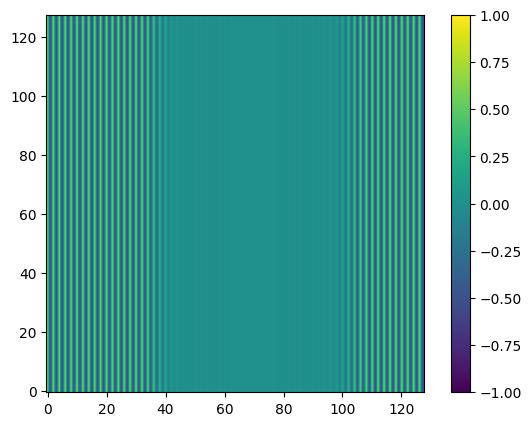

In [69]:
in_field = ti.Vector.field(n=NX, dtype=ti.f64, shape=(NZ,NY))
in_field.from_numpy(initialize_field(NX, NY, NZ, mode="vertical-bars"))
out_field = ti.Vector.field(n=NX, dtype=ti.f64, shape=(NZ,NY))
out_field.from_numpy(np.empty((NZ,NY,NX)))
out_field = taichi_vec_1D_same_col(in_field, out_field)
out_field = out_field.to_numpy()
plot_field(out_field)

In [70]:
%%timeit -o in_field = ti.Vector.field(n=NX, dtype=ti.f64, shape=(NZ,NY)); in_field.from_numpy(initialize_field(NX, NY, NZ)); out_field = ti.Vector.field(n=NX, dtype=ti.f64, shape=(NZ,NY)); out_field.from_numpy(np.empty((NZ,NY,NX)))
out_field = taichi_vec_1D_same_col(in_field, out_field)

264 ms ± 18.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 264 ms ± 18.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

With GPU backend the Vector field attempt gets actually much slower, most possibly limited by cache usage. Considering the results above, **we will stick to the regular 3D field build-up for the following tests**.

In [71]:
md(f"""
| Function                      | Time                                                    |
|:------------------------------|--------------------------------------------------------:|
| `list_1D_same_col()`          |  {time_list_1D_same_col:.1f}s                           |
| `numpy_1D_same_col()`         |  {time_numpy_1D_same_col * 1e3:.0f}ms                   |
| `numba_1D_same_col()`         |  {time_numba_1D_same_col * 1e3:.1f}ms                   |
| `gt4py_kfirst_1D_same_col()`  |  {time_gt4py_1D_same_col * 1e3:.1f}ms                   |
| `numexpr_1D_same_col()`       |  {time_numexpr_1D_same_col * 1e3:.1f}ms                 |
| `taichi_cpu_1D_same_col()`    |  {result_taichi_cpu_1D_same_col.average * 1e3:.1f}ms    |
| `taichi_gpu_1D_same_col()`    |  {result_taichi_gpu_1D_same_col.average * 1e3:.1f}ms    |
""")


| Function                      | Time                                                    |
|:------------------------------|--------------------------------------------------------:|
| `list_1D_same_col()`          |  14.9s                           |
| `numpy_1D_same_col()`         |  113ms                   |
| `numba_1D_same_col()`         |  3.6ms                   |
| `gt4py_kfirst_1D_same_col()`  |  7.3ms                   |
| `numexpr_1D_same_col()`       |  97.7ms                 |
| `taichi_cpu_1D_same_col()`    |  61.8ms    |
| `taichi_gpu_1D_same_col()`    |  21.9ms    |


### Same Row

#### CPU backend

In [72]:
ti.init(arch=ti.cpu, default_fp=ti.f64)

[Taichi] Starting on arch=x64


In [73]:
@ti.kernel
def taichi_field_diff_1D_same_row():
    for k, i in ti.ndrange(NZ, NX):
        for j in range(NY-1):
            out_field[k, j, i] = 0.5 * (in_field[k, j+1, i] - in_field[k, j, i])
        out_field[k, NY-1, i] = 0.5 * (in_field[k, 0, i] - in_field[k, NY-1, i])

def taichi_field_1D_same_row(in_field, out_field):
    for n in range(N_ITER):
        taichi_field_diff_1D_same_row()
        if n < N_ITER - 1:
            in_field.copy_from(out_field)
    return out_field

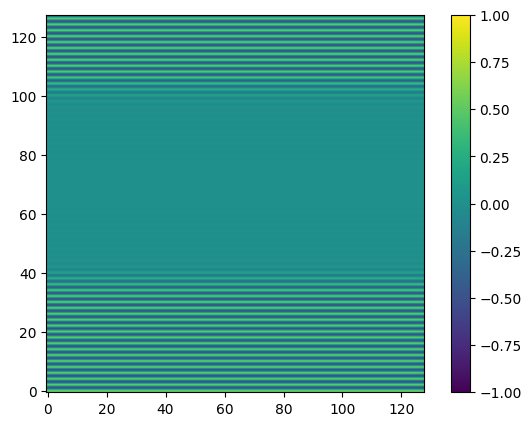

In [74]:
in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
in_field.from_numpy(initialize_field(NX, NY, NZ, mode="horizontal-bars"))
out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
out_field.from_numpy(np.empty((NZ,NY,NX)))
out_field = taichi_field_1D_same_row(in_field, out_field)
out_field = out_field.to_numpy()
plot_field(out_field)

In [75]:
%%timeit -o in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); in_field.from_numpy(initialize_field(NX, NY, NZ)); out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); out_field.from_numpy(np.empty((NZ,NY,NX)))
taichi_field_1D_same_row(in_field, out_field)

85.8 ms ± 825 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 85.8 ms ± 825 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)>

According to what we've learnt, the default `ti.field` memory layout is not optimized. Here using Taichi we can customize a `j-first` memory layout: j-indices are continous, and then i-indices, and k-indices at last. The field will use the same function(Taichi kernel here) without any further adjustment.

[Taichi] Starting on arch=x64


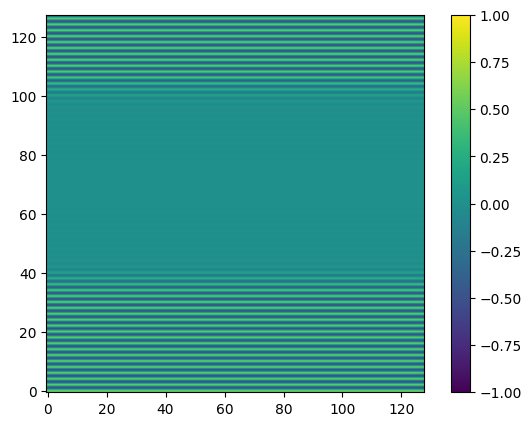

In [76]:
ti.init(arch=ti.cpu, default_fp=ti.f64)
in_field = ti.field(dtype=ti.f64)
ti.root.dense(ti.i, NZ).dense(ti.k, NX).dense(ti.j, NY).place(in_field)
in_field.from_numpy(initialize_field(NX, NY, NZ, mode="horizontal-bars"))
out_field = ti.field(dtype=ti.f64)
ti.root.dense(ti.i, NZ).dense(ti.k, NX).dense(ti.j, NY).place(out_field)
out_field.from_numpy(np.empty((NZ,NY,NX)))
out_field = taichi_field_1D_same_row(in_field, out_field)
out_field = out_field.to_numpy()
plot_field(out_field)

In [77]:
%%timeit -o in_field = ti.field(dtype=ti.f64); ti.root.dense(ti.i, NZ).dense(ti.k, NX).dense(ti.j, NY).place(in_field); in_field.from_numpy(initialize_field(NX, NY, NZ)); out_field = ti.field(dtype=ti.f64); ti.root.dense(ti.i, NZ).dense(ti.k, NX).dense(ti.j, NY).place(out_field); out_field.from_numpy(np.empty((NZ,NY,NX)))
out_field = taichi_field_1D_same_row(in_field, out_field)

62.5 ms ± 1.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 62.5 ms ± 1.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [78]:
result_taichi_cpu_1D_same_row = _
save_result(result_taichi_cpu_1D_same_row, "taichi_cpu_1D_same_row")

Yes! With this customized memory layout the codes are even faster, similar to the column stencil result, proving that our change of memory layout does accelerate the codes.

#### GPU backend

In [79]:
ti.init(arch=ti.gpu, default_fp=ti.f64)

[Taichi] Starting on arch=cuda


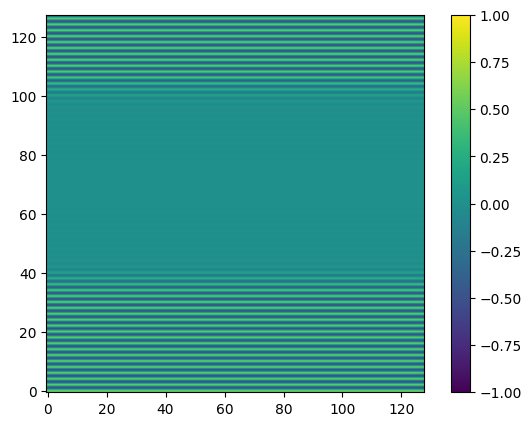

In [80]:
in_field = ti.field(dtype=ti.f64)
ti.root.dense(ti.i, NZ).dense(ti.k, NX).dense(ti.j, NY).place(in_field)
in_field.from_numpy(initialize_field(NX, NY, NZ, mode="horizontal-bars"))
out_field = ti.field(dtype=ti.f64)
ti.root.dense(ti.i, NZ).dense(ti.k, NX).dense(ti.j, NY).place(out_field)
out_field.from_numpy(np.empty((NZ,NY,NX)))
out_field = taichi_field_1D_same_row(in_field, out_field)
out_field = out_field.to_numpy()
plot_field(out_field)

In [81]:
%%timeit -o in_field = ti.field(dtype=ti.f64); ti.root.dense(ti.i, NZ).dense(ti.k, NX).dense(ti.j, NY).place(in_field); in_field.from_numpy(initialize_field(NX, NY, NZ)); out_field = ti.field(dtype=ti.f64); ti.root.dense(ti.i, NZ).dense(ti.k, NX).dense(ti.j, NY).place(out_field); out_field.from_numpy(np.empty((NZ,NY,NX)))
out_field = taichi_field_1D_same_row(in_field, out_field)

21.7 ms ± 1.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 21.7 ms ± 1.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [82]:
result_taichi_gpu_1D_same_row = _
save_result(result_taichi_gpu_1D_same_row, "taichi_gpu_1D_same_row")

Here GPU shows similar acceleration we've seen for column stencil codes.

## 2D stencil

Writing a 2D stencil code using Taichi is mostly alike with writing a numpy version, just that we cannot use array slices indices but only pointwise for-loop. Instead of using python functions we use `ti.kernel` and `ti.func`. `ti.func` helps to organize the code in a more readable way, and will be fully inclined into the new functions or kernels when compiling, meaning that no overhead will be generated when calling `ti.func`. However, it can only be called by `ti.func` or `ti.kernel`. `ti.kernel`, on the other hand, cannot be called by other kernels or functions, and have certain limitations other than those mentioned before. For example, you cannot define fields or call `copy_from()` function inside a kernel. These limitations makes the Taichi version 2D codes a bit tricky.

Just like previous DSLs, the performance of Taichi version 2D stencil codes will be compared with the numpy version from the course.

### CPU backend

First we work with a CPU backend.

In [83]:
ti.init(arch=ti.cpu, default_fp=ti.f64)

[Taichi] Starting on arch=x64


In [84]:
from stencil2d import laplacian, update_halo, apply_diffusion

Now we write Laplacian function with a `@ti.func` decorator.

In [85]:
@ti.func
def laplacian_taichi(in_field, lap_field, num_halo, extend=0):
    ib = num_halo - extend
    ie = NX - num_halo + extend
    jb = num_halo - extend
    je = NY - num_halo + extend
    
    for k, j, i in ti.ndrange(NZ,NY,NX):
        if ib <= i < ie and jb <= j < je:
            lap_field[k, j, i] = (
                -4.0 * in_field[k, j, i]
                + in_field[k, j, i - 1]
                + in_field[k, j, i + 1]
                + in_field[k, j - 1, i]
                + in_field[k, j + 1, i]
            )

# We define the kernal so that we can call it and compare its speed.
@ti.kernel
def laplacian_taichi_kernel():
    laplacian_taichi(in_field, out_field, 2)

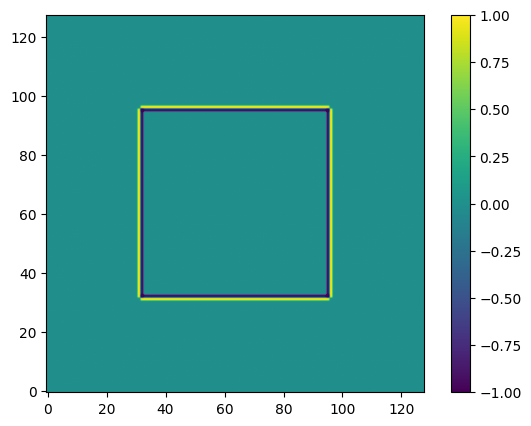

In [86]:
in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
in_field.from_numpy(initialize_field(NX, NY, NZ, mode="square"))
out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
out_field.from_numpy(np.zeros((NZ,NY,NX)))
laplacian_taichi_kernel()
out_field = out_field.to_numpy()
plot_field(out_field)

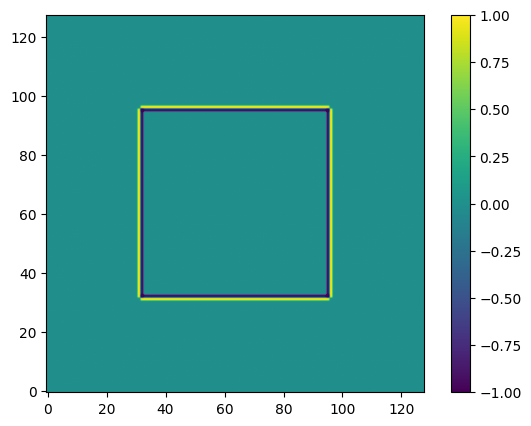

In [87]:
# Test if the laplacian works correctly.
in_field_2 = initialize_field(NX, NY, NZ, mode="square")
out_field_2 = np.zeros((NZ,NY,NX))
laplacian(in_field_2, out_field_2, num_halo=2)
plot_field(out_field_2)

In [88]:
np.array_equal(out_field, out_field_2)

True

In [89]:
%%timeit -o in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); in_field.from_numpy(initialize_field(NX, NY, NZ)); out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); out_field.from_numpy(np.empty((NZ,NY,NX)))
laplacian_taichi_kernel()

873 µs ± 29.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


<TimeitResult : 873 µs ± 29.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)>

In [90]:
%%timeit -o in_field = initialize_field(NX, NY, NZ); out_field = np.empty((NZ,NY,NX))
laplacian(in_field, out_field, num_halo=2, extend=0)

6.96 ms ± 19.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 6.96 ms ± 19.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

We can see that the laplacian part is about 10 times faster with Taichi kernel compiling.

In [91]:
@ti.func
def update_halo_taichi(field, num_halo):
    for k, j, i in ti.ndrange(NZ, num_halo, NX - 2 * num_halo):
        # bottom and top edge (without corners)
        field[k, j, i + num_halo] = field[k, j + NY - 2 * num_halo, i + num_halo]
        field[k, j + NY - num_halo, i + num_halo] = field[k, j + num_halo, i + num_halo]
    
    for k, j, i in ti.ndrange(NZ, NY, num_halo):
        # left and right edge (including corners)
        field[k, j, i] = field[k, j, i + NX - 2 * num_halo]
        field[k, j, i + NX - num_halo] = field[k, j, i + num_halo]

@ti.kernel
def update_halo_taichi_kernel():
    update_halo_taichi(out_field, num_halo)

True

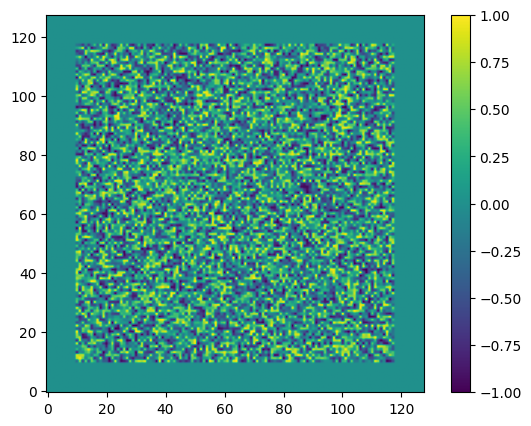

In [92]:
out_field_np = initialize_field(NX, NY, NZ, num_halo=10)
out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
out_field.from_numpy(out_field_np)
plot_field(out_field_np)
copy_out_field = out_field.to_numpy()
np.array_equal(out_field_np, copy_out_field)

False

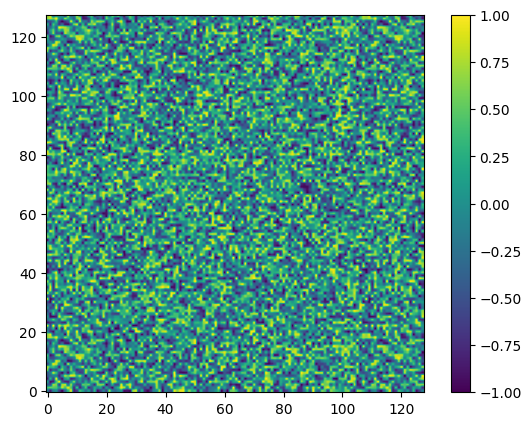

In [93]:
update_halo(out_field_np, num_halo=10)
plot_field(out_field_np)
np.array_equal(out_field_np, copy_out_field)

True

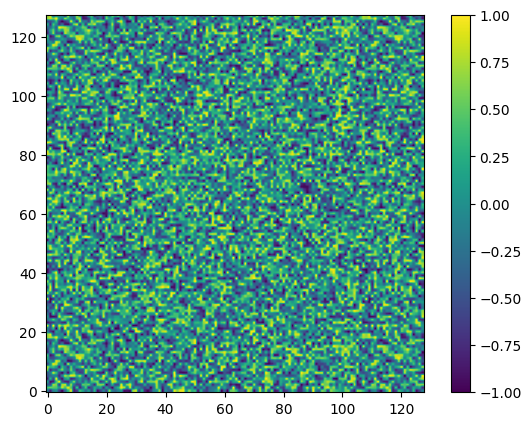

In [94]:
num_halo = 10
update_halo_taichi_kernel()
plot_field(out_field.to_numpy())
np.array_equal(out_field_np, out_field.to_numpy())

In [95]:
%%timeit in_field = initialize_field(NX, NY, NZ)
update_halo(in_field, num_halo=2)

643 µs ± 191 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [96]:
#timeit decorator seems to have a conflice with Taichi, so we split them to two blocks
ti.init(arch=ti.cpu, default_fp=ti.f64)
out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
out_field.from_numpy(initialize_field(NX, NY, NZ, num_halo=2))
num_halo = 2

[Taichi] Starting on arch=x64


In [97]:
%%timeit 
update_halo_taichi_kernel()

166 µs ± 6.51 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


The halo update function also runs much faster with Taichi acceleration.

Now we start by compiling all these functions in `ti.func` form into one single `ti.kernel` called `diffusion_step_taichi()`, as calling multiple kernels drags down the overall speed with unnecessary overheads. Then we use a python function `apply_diffusion_taichi` to wrap it up with all the sections that cannot be operated inside `ti.kernel`. In the end we also need to include `update_halo_taichi` function again, so we compile the `ti.func` into `ti.kernel`.

In [98]:
@ti.func
def diffusion_taichi(in_field, out_field, num_halo):
    alpha = 1.0 / 32.0
    for k, j, i in ti.ndrange(NZ, NY, NX):
        if num_halo <= i < NX - num_halo and num_halo <= j < NY - num_halo:
            out_field[k, j, i] = in_field[k, j, i] - alpha * out_field[k, j, i]

@ti.kernel
def diffusion_step_taichi():
    update_halo_taichi(in_field, num_halo)
    laplacian_taichi(in_field=in_field, lap_field=tmp_field, num_halo=num_halo, extend=1)
    laplacian_taichi(in_field=tmp_field, lap_field=out_field, num_halo=num_halo, extend=0)
    diffusion_taichi(in_field, out_field, num_halo)

def apply_diffusion_taichi(in_field, out_field, num_halo, num_iter=1):
    for n in range(num_iter):
        diffusion_step_taichi()
        
        if n < num_iter - 1:
            in_field.copy_from(out_field)
        else:
            update_halo_taichi_kernel()

[Taichi] Starting on arch=x64


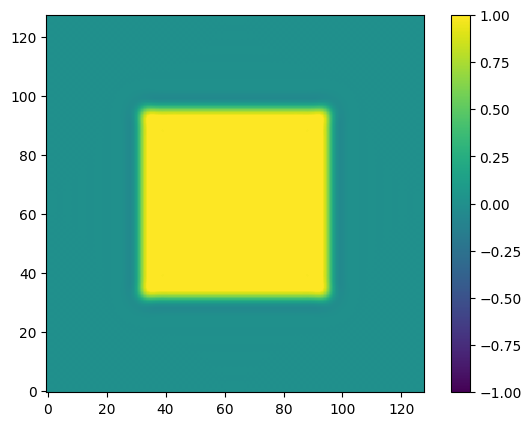

In [99]:
ti.init(arch=ti.cpu, default_fp=ti.f64)
in_field_np = initialize_field(NX, NY, NZ, mode="square", num_halo=0)
in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
in_field.from_numpy(initialize_field(NX, NY, NZ, mode="square", num_halo=0))

out_field_np = np.empty_like(in_field_np)
out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
out_field.from_numpy(out_field_np)

tmp_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
tmp_field.from_numpy(out_field_np)

apply_diffusion(in_field_np, out_field_np, num_halo=2, num_iter=N_ITER)
apply_diffusion_taichi(in_field, out_field, num_halo=2, num_iter=N_ITER)

plot_field(out_field.to_numpy())
# Taichi connot pass the almost_equal test either, so we just skip it
# np.testing.assert_almost_equal(out_field_np, out_field.to_numpy())

In [100]:
%%timeit -o in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); in_field.from_numpy(initialize_field(NX, NY, NZ, mode="square", num_halo=0)); out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); out_field.from_numpy(np.empty((NZ,NY,NX)))
apply_diffusion_taichi(in_field, out_field, num_halo=2, num_iter=N_ITER)

215 ms ± 36.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 215 ms ± 36.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [101]:
result_taichi_cpu_2D = _
save_result(result_taichi_cpu_2D, "taichi_cpu_2D")

In [102]:
time_numpy_2D = read_results("numpy_2D")
time_numba_2D = read_results("numba_2D")
time_gt4py_2D = read_results("gt4py_ifirst_2D")

taichi_vs_numpy = compare_results(result_taichi_cpu_2D.average, time_numpy_2D)

md(f"""
Under CPU backend, Taichi codes runs **{taichi_vs_numpy} times faster than the original python code**. However, it's slower than 
Numba and GT4Py ({time_numba_2D * 1e3:.1f} ms and {time_gt4py_2D * 1e3:.1f} ms respectively).
""")


Under CPU backend, Taichi codes runs **~5.0 times faster than the original python code**. However, it's slower than 
Numba and GT4Py (22.5 ms and 32.6 ms respectively).


It's also worth mentioning that Taichi result is slightly different from the numpy version, with a max absolute error of around $3\text{~}4\times10^{-4}$. This indicates that there might be a floating error inside Taichi. In theory with `ti.init(default_fp=ti.f64)`, all floating number should be converted to `float64` format, but it seem that inside Taichi there can be a precision loss. There is an extra setting according to Taichi document that we can set `ti.init(fast_math=False)`, but it turns out not to change the errors, but only dragging the computation time.

Now let's check the GPU backend performance.

### GPU backend

In [103]:
ti.init(arch=ti.gpu, default_fp=ti.f64)

[Taichi] Starting on arch=cuda


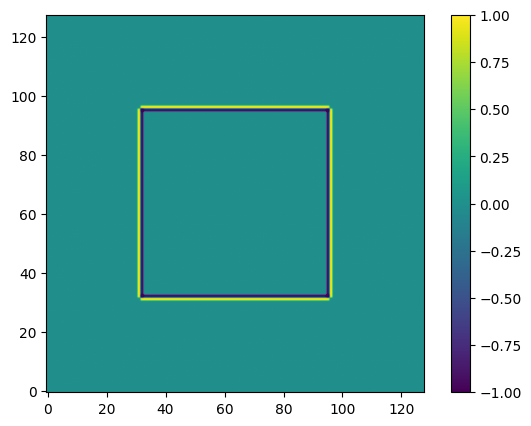

In [104]:
in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
in_field.from_numpy(initialize_field(NX, NY, NZ, mode="square"))
out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
out_field.from_numpy(np.zeros((NZ,NY,NX)))
laplacian_taichi_kernel()
out_field = out_field.to_numpy()
plot_field(out_field)

In [105]:
%%timeit -o in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); in_field.from_numpy(initialize_field(NX, NY, NZ)); out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); out_field.from_numpy(np.empty((NZ,NY,NX)))
laplacian_taichi_kernel()

134 µs ± 804 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


<TimeitResult : 134 µs ± 804 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)>

True

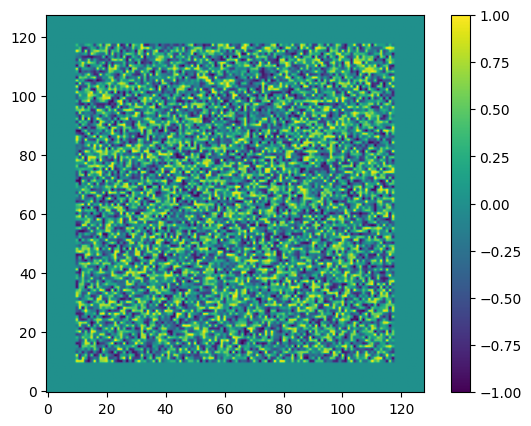

In [106]:
out_field_np = initialize_field(NX, NY, NZ, num_halo=10)
out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
out_field.from_numpy(out_field_np)
plot_field(out_field_np)
copy_out_field = out_field.to_numpy()
np.array_equal(out_field_np, copy_out_field)

False

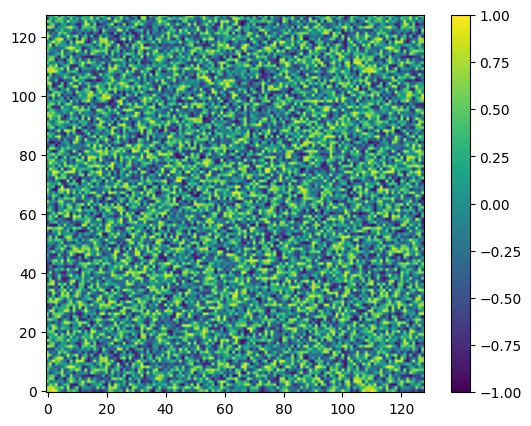

In [107]:
update_halo(out_field_np, num_halo=10)
plot_field(out_field_np)
np.array_equal(out_field_np, copy_out_field)

True

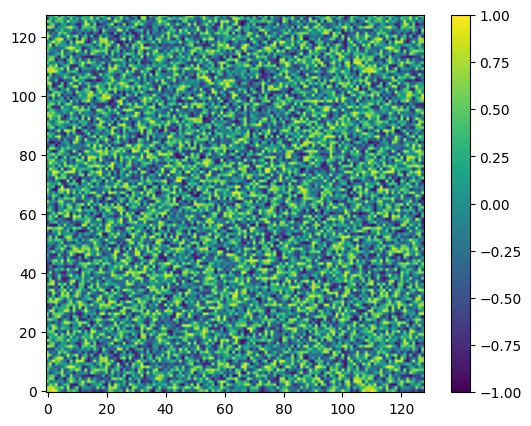

In [108]:
num_halo = 10
update_halo_taichi_kernel()
plot_field(out_field.to_numpy())
np.array_equal(out_field_np, out_field.to_numpy())

In [109]:
#timeit decorator seems to have a conflice with Taichi, so we split them to two blocks
ti.init(arch=ti.gpu, default_fp=ti.f64)
out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
out_field.from_numpy(initialize_field(NX, NY, NZ, num_halo=2))
num_halo = 2

[Taichi] Starting on arch=cuda


In [110]:
%%timeit 
update_halo_taichi_kernel()

134 µs ± 1.38 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


[Taichi] Starting on arch=cuda


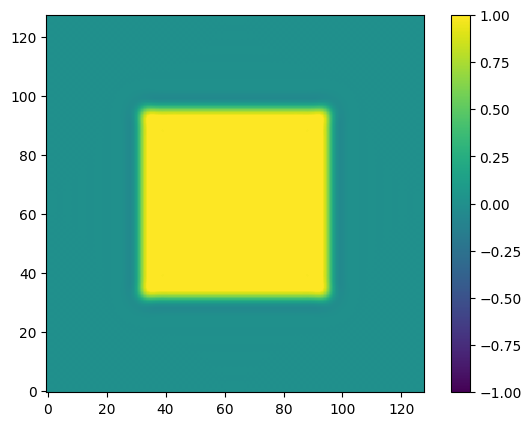

In [111]:
ti.init(arch=ti.gpu, default_fp=ti.f64)
in_field_np = initialize_field(NX, NY, NZ, mode="square", num_halo=0)
in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
in_field.from_numpy(initialize_field(NX, NY, NZ, mode="square", num_halo=0))

out_field_np = np.empty_like(in_field_np)
out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
out_field.from_numpy(out_field_np)

tmp_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
tmp_field.from_numpy(out_field_np)

apply_diffusion(in_field_np, out_field_np, num_halo=2, num_iter=N_ITER)
apply_diffusion_taichi(in_field, out_field, num_halo=2, num_iter=N_ITER)

plot_field(out_field.to_numpy())
# Taichi connot pass the almost_equal test either, so we just skip it
# np.testing.assert_almost_equal(out_field_np, out_field.to_numpy())

In [112]:
%%timeit -o in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); in_field.from_numpy(initialize_field(NX, NY, NZ, mode="square", num_halo=0)); out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); out_field.from_numpy(np.empty((NZ,NY,NX)))
apply_diffusion_taichi(in_field, out_field, num_halo=2, num_iter=N_ITER)

23.2 ms ± 1.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 23.2 ms ± 1.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [113]:
result_taichi_gpu_2D = _
save_result(result_taichi_gpu_2D, "taichi_gpu_2D")

In [114]:
taichi_vs_numpy = compare_results(result_taichi_gpu_2D.average, time_numpy_2D)
taichi_gpu_vs_taichi_cpu = compare_results(result_taichi_gpu_2D.average, result_taichi_cpu_2D.average)

md(f"""
Under GPU backend, Taichi codes runs **{taichi_gpu_vs_taichi_cpu} times faster than its CPU version and {taichi_vs_numpy} times 
faster than the original python code**. Now it has a comparable performance with Numba and GT4Py. The introduction of GPU really 
boosts 2D diffusion stencil computation.
""")


Under GPU backend, Taichi codes runs **~9.3 times faster than its CPU version and ~46 times 
faster than the original python code**. Now it has a comparable performance with Numba and GT4Py. The introduction of GPU really 
boosts 2D diffusion stencil computation.


In [115]:
md(f"""
| Function                    | Time                                           |
|:----------------------------|-----------------------------------------------:|
| `numpy_2D()`                |  {time_numpy_2D:.1f}s                          |
| `numba_2D()`                |  {time_numba_2D * 1e3:.1f}ms                   |
| `gt4py_ifirst_2D()`         |  {time_gt4py_2D * 1e3:.1f}ms                   |
| `taichi_cpu_2D()`           |  {result_taichi_cpu_2D.average * 1e3:.1f}ms    |
| `taichi_gpu_2D()`           |  {result_taichi_gpu_2D.average * 1e3:.1f}ms    |
""")


| Function                    | Time                                           |
|:----------------------------|-----------------------------------------------:|
| `numpy_2D()`                |  1.1s                          |
| `numba_2D()`                |  22.5ms                   |
| `gt4py_ifirst_2D()`         |  32.6ms                   |
| `taichi_cpu_2D()`           |  214.9ms    |
| `taichi_gpu_2D()`           |  23.2ms    |


With comparison to Numba we can see Taichi and Numba have different codes that they're good at. Actually, the Taichi official document gives their suggestion in the FAQ part:

> **Numba is recommended if your functions involve vectorization of NumPy arrays**. Compared with Numba, Taichi enjoys the following advantages:

> * Taichi provides advanced features, including quantized data types, dataclasses and sparse data structures, and allows you to adjust memory layout flexibly. These features are especially helpful when a program handles massive amounts of data. However, **Numba only performs best when dealing with dense NumPy arrays**.

> * Taichi can run on different GPU backends, **making large-scale parallel programming (such as particle simulation or rendering) much more efficient**. But it would be hard even to imagine writing a renderer in Numba.

Based on these statements, Numba seems to be the better choice over Taichi in our case as it's not a really big stencil, and no special dataclasses or sparse data structure involved.